In [75]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
# import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree
# preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Creamos una copia del dataset para comenzar a trabajar.

In [76]:
ds_hotel=pd.read_csv('./hotels_train_filtrado2.csv')
ds_trabajo = ds_hotel.copy()

Para la detección de outliers en nuestro dataset, vamos a comenzar realizando un análisis univariado para cada una de sus columnas y decidiremos qué tratamiento darles a aquellos valores atípicos que encontremos.

In [77]:
ds_trabajo.columns.to_list()

['hotel',
 'lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'customer_type',
 'adr',
 'total_of_special_requests',
 'reservation_status_date',
 'id',
 'is_canceled',
 'arrival_date',
 'region',
 'agent_specified',
 'total_guests',
 'more_than_zero_days_in_waiting_list',
 'season',
 'room_type_match']

En la notebook_1, analizamos las distribuciones de todas estas columnas y ya observamos que algunas de ellas no presentaban valores atípicos:
- `hotel` no presenta valores atípicos. Analizamos anteriormente su distribución mediante un gráfico de torta y observamos que sus dos categorías presentan porcentajes considerables (siendo estos 68% y 32%)
- `season` no presenta valores atípicos. Vimos en un barplot anteriormente que todas las categorías tienen frecuencias considerables
- `is_repeated_guest`, `is_canceled`, `agent_specified`, `more_than_zero_days_in_waiting_list`, `room_type_match` son booleanas y no presentan valores atípicos

En el caso de `lead_time`, habíamos analizado su distribución mediante un boxplot y presentaba outliers.

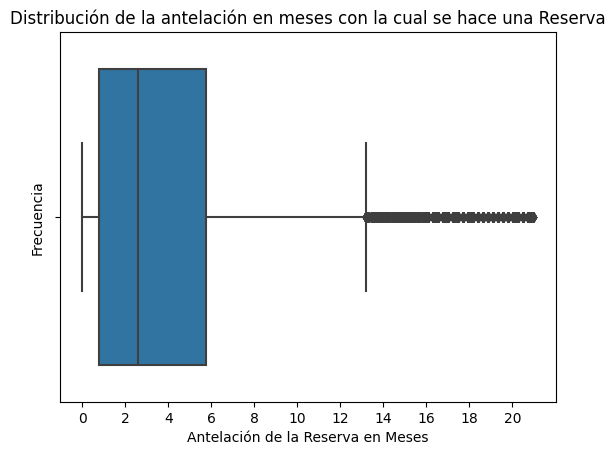

In [78]:
sns.boxplot(x=ds_trabajo["lead_time"])
plt.xticks(range(0, 22, 2))
plt.xlabel('Antelación de la Reserva en Meses')
plt.ylabel('Frecuencia')
plt.title('Distribución de la antelación en meses con la cual se hace una Reserva')
plt.show()

In [79]:
#Cuartiles
Q1_lead_time=np.quantile(ds_trabajo.lead_time,0.25)
Q3_lead_time=np.quantile(ds_trabajo.lead_time,0.75)

#Rango intercuartil
IQR_lead_time=Q3_lead_time-Q1_lead_time

#Limite inferior Outliers
out_inf=Q1_lead_time-1.5*IQR_lead_time
out_sup=Q3_lead_time+1.5*IQR_lead_time
print(out_inf)
print(out_sup)

-6.683333333333334
13.183333333333334


Vamos a ver cuántos valores están 1.5 veces por debajo y por encima del IQR para `lead_time`.

In [80]:
outliers_inf = ds_trabajo[ds_trabajo['lead_time'] < out_inf]
print("Outliers inferiores:",outliers_inf["lead_time"].count())
outliers_sup = ds_trabajo[ds_trabajo['lead_time'] > out_sup]
print("Outliers superiores:",outliers_sup["lead_time"].count())

Outliers inferiores: 0
Outliers superiores: 1369


No tenemos negativos en esta columna al tratarse de una cantidad de meses, (ya habíamos hecho este análisis), por lo tanto no tendremos outliers por este lado. En cuanto a los outliers superiores, es una cantidad reducida de registros. Sin embargo, creemos que el tiempo de antelación con el cual se realiza una reserva puede ser un factor importante para determinar una cancelación. Además, en la notebook_1 habíamos hecho un scatter plot de `lead_time` junto con `is_canceled` y notamos que a partir de los 10 meses se cancelaba con mayor frecuencia. Por lo tanto vamos a conservar estos outliers.

En cuanto a `stays_in_weekend_nights` vemos en un boxplot que tenemos algunos valores atípicos.

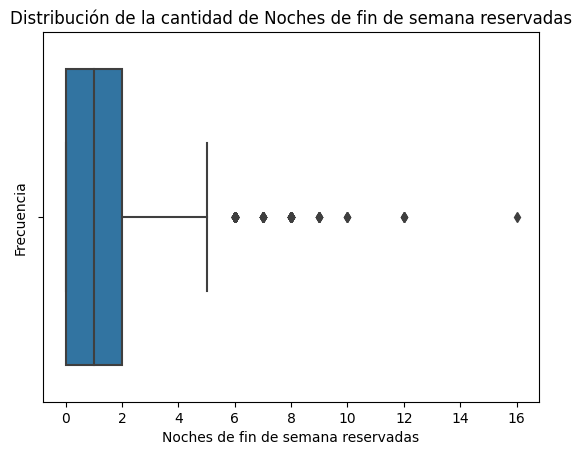

In [81]:
sns.boxplot(x=ds_trabajo["stays_in_weekend_nights"])
plt.xlabel('Noches de fin de semana reservadas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Noches de fin de semana reservadas')
plt.show()

In [82]:
#Cuartiles
Q1_stays_in_weekend_nights=np.quantile(ds_trabajo.stays_in_weekend_nights,0.25)
Q3_stays_in_weekend_nights=np.quantile(ds_trabajo.stays_in_weekend_nights,0.75)

#Rango intercuartil
IQR_stays_in_weekend_nights=Q3_stays_in_weekend_nights-Q1_stays_in_weekend_nights

#Limite inferior Outliers
out_inf=Q1_stays_in_weekend_nights-1.5*IQR_stays_in_weekend_nights
out_sup=Q3_stays_in_weekend_nights+1.5*IQR_stays_in_weekend_nights
print(out_inf)
print(out_sup)

-3.0
5.0


Esta columna tampoco tiene outliers inferiores (es una cantidad), pero sí tiene algunos pocos superiores. Vamos a analizar la relación de aquellos registros con el target `is_canceled`.

In [83]:
outliers_inf = ds_trabajo[ds_trabajo['stays_in_weekend_nights'] < out_inf]
print("Outliers inferiores:", outliers_inf["stays_in_weekend_nights"].count())

outliers_sup = ds_trabajo[ds_trabajo['stays_in_weekend_nights'] > out_sup]
print("Outliers superiores:", outliers_sup["stays_in_weekend_nights"].count())

Outliers inferiores: 0
Outliers superiores: 144


In [84]:
ds_trabajo['arrival_date']
# q1 = ds_trabajo['reservation_status_date'].quantile(0.25)
# q3 = ds_trabajo['reservation_status_date'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + (1.5 * iqr)
# lower_bound = q1 - (1.5 * iqr)
# outliers = ds_trabajo[(ds_trabajo['reservation_status_date'] < lower_bound) | (ds_trabajo['reservation_status_date'] > upper_bound)]
# outliers
# # Creación del gráfico
# ax = sns.displot(ds_trabajo['reservation_status_date'], kde=True)
# ax = sns.scatterplot(data=outliers, x='reservation_status_date', y=[0]*len(outliers), color='red', marker='x', s=100)
# ax.set(xlabel='Fecha', title='Distribución de Fechas con Outliers')

# plt.show()


0        2016-09-05
1        2015-10-31
2        2016-10-13
3        2016-12-12
4        2017-03-19
            ...    
61908    2017-01-27
61909    2016-09-02
61910    2017-05-08
61911    2015-10-10
61912    2016-04-17
Name: arrival_date, Length: 61913, dtype: object

Observamos que, si bien son pocos registros, cuando se reservan más de 5 noches de fin de semana hay una tendencia marcada a cancelar la reserva. Por este motivo, vamos a conservar estos outliers.

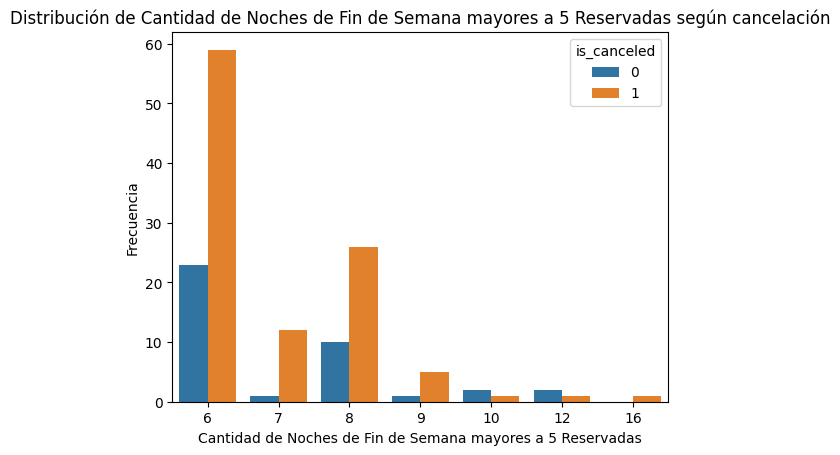

In [85]:
df = ds_trabajo.loc[ds_trabajo['stays_in_weekend_nights'] > 5]
grafico = sns.countplot(x=df['stays_in_weekend_nights'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de Noches de Fin de Semana mayores a 5 Reservadas')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de Noches de Fin de Semana mayores a 5 Reservadas según cancelación")

plt.show()

En cuanto a `stays_in_week_nights`, sucede algo similar a `stays_in_weekend_nights`. Tenemos algunos valores atípicos superiores.

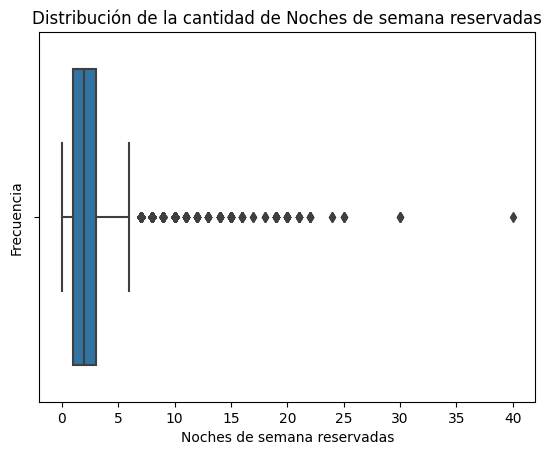

In [86]:
sns.boxplot(x=ds_trabajo["stays_in_week_nights"])
plt.xlabel('Noches de semana reservadas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Noches de semana reservadas')
plt.show()

In [87]:
#Cuartiles
Q1_stays_in_week_nights=np.quantile(ds_trabajo.stays_in_week_nights,0.25)
Q3_stays_in_week_nights=np.quantile(ds_trabajo.stays_in_week_nights,0.75)

#Rango intercuartil
IQR_stays_in_week_nights=Q3_stays_in_week_nights-Q1_stays_in_week_nights

#Limite inferior Outliers
out_inf=Q1_stays_in_week_nights-1.5*IQR_stays_in_week_nights
out_sup=Q3_stays_in_week_nights+1.5*IQR_stays_in_week_nights
print(out_inf)
print(out_sup)

-2.0
6.0


In [88]:
outliers_inf = ds_trabajo[ds_trabajo['stays_in_week_nights'] < out_inf]
print("Outliers inferiores:", outliers_inf["stays_in_week_nights"].count())

outliers_sup = ds_trabajo[ds_trabajo['stays_in_week_nights'] > out_sup]
print("Outliers superiores:",outliers_sup["stays_in_week_nights"].count())

Outliers inferiores: 0
Outliers superiores: 1724


Si bien son pocos outliers superiores, creemos que hay una variabilidad respecto al target `is_canceled` para estos registros. Por otro lado, creemos que podemos obtener información haciendo un análisis multivariado de `stays_in_week_nights`, `stays_in_weekend_nights` (ambas están correlacionadas) y el target `is_canceled`. TODO

In [89]:
#Calulo el vector de medias
vmedias=np.mean(ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

ds_trabajo['mahalanobis']=mahal.diagonal()

<Axes: ylabel='mahalanobis'>

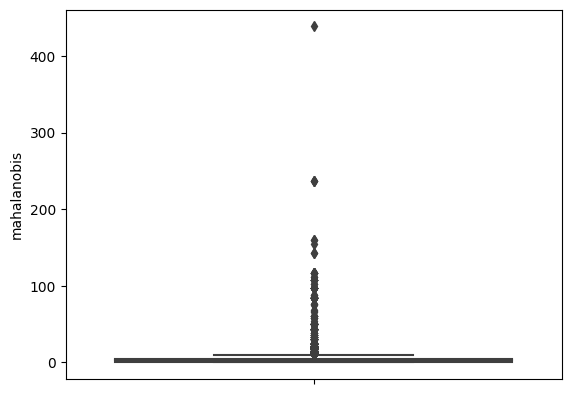

In [90]:
sns.boxplot(y=ds_trabajo.mahalanobis)

Tomamos un umbral de 95.

In [91]:
umbral=95

#Observaciones anómalas
ds_trabajo[ds_trabajo['mahalanobis']>umbral]

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,id,is_canceled,arrival_date,region,agent_specified,total_guests,more_than_zero_days_in_waiting_list,season,room_type_match,mahalanobis
3855,City Hotel,4.100000,10,20,Online TA,TA/TO,0,0,0,1,...,37701593-dc47-40a3-ba09-fdcf7d769807,1,2017-01-15,Africa,1,3,0,Winter,True,111.109353
5295,Resort Hotel,6.066667,8,22,Online TA,TA/TO,0,0,0,0,...,9cd638c4-6217-4870-b5ef-d0e82f322bfb,1,2017-03-01,Europe,1,4,0,Winter,True,117.288004
6423,City Hotel,0.300000,8,21,Online TA,TA/TO,0,0,0,0,...,73e4b997-45b7-4a5c-9a90-0b6824bc1e7d,1,2017-01-27,Africa,1,3,0,Winter,True,106.967671
9229,Resort Hotel,0.433333,9,24,Corporate,Corporate,0,0,0,0,...,78c96b33-4f25-4f97-81d5-f63b0d64a201,1,2016-04-25,Europe,0,2,0,Spring,True,142.932491
10018,City Hotel,1.400000,8,20,Online TA,TA/TO,0,0,0,2,...,7dc77c3a-face-4ebb-913a-cc914336b011,0,2016-08-27,Americas,1,1,0,Summer,False,97.386883
12477,Resort Hotel,2.433333,8,21,Online TA,TA/TO,0,0,0,0,...,c2cbf793-facc-40c6-b43c-0103e0a4fe13,1,2017-01-27,Asia,1,1,0,Winter,True,106.967671
14236,City Hotel,0.833333,9,24,Direct,Direct,0,0,0,1,...,ed391057-b6cd-4c4b-a380-ec3180dbd9ec,1,2015-11-30,Europe,0,2,0,Autumn,True,142.932491
14877,City Hotel,2.200000,8,20,Online TA,TA/TO,0,0,0,0,...,10ecc525-1927-4b4d-a9b8-b409707a855c,1,2016-11-20,Africa,1,4,0,Autumn,True,97.386883
15728,Resort Hotel,4.366667,8,20,Online TA,TA/TO,0,0,0,0,...,7bc6b905-9baa-4c0c-818f-1e146c4f408d,0,2017-01-08,Europe,1,2,0,Winter,False,97.386883
18282,Resort Hotel,9.466667,8,20,Offline TA/TO,TA/TO,0,0,0,0,...,d8b0dc47-1d91-42d7-b3b4-e106123a972f,1,2016-01-12,Europe,1,2,0,Winter,True,97.386883


Vemos que hay 46 registros outliers según Mahalanobis. Los vamos a visualizar en un scatter plot.

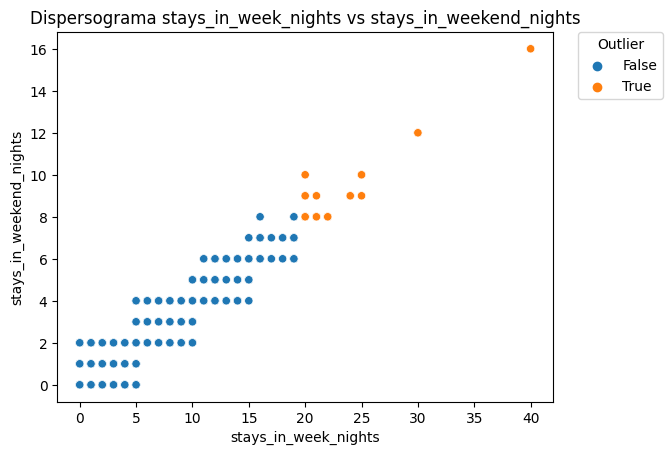

In [92]:
#Grafico scatter
es_outlier = (ds_trabajo['mahalanobis'] > umbral)

sns.scatterplot(x=ds_trabajo.stays_in_week_nights,y=ds_trabajo.stays_in_weekend_nights, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma stays_in_week_nights vs stays_in_weekend_nights')
plt.show()

ds_trabajo = ds_trabajo.drop('mahalanobis',axis=1)

Viendo este gráfico observamos nuevamente que ambas variables están correlacionadas. Hay muy pocos outliers a partir de aproximadamente las 20 noches de semana reservadas.  Si bien son outliers porque no tienen una distribución similar a la regular, la tendencia es la misma: entre más noches de semana se reservan, más noches de fin de semana, lo cual parece lógico.
Veremos su relación con el target.

In [93]:
#Calulo el vector de medias
vmedias=np.mean(ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights','is_canceled']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights','is_canceled']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=ds_trabajo[['stays_in_week_nights','stays_in_weekend_nights','is_canceled']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

ds_trabajo['mahalanobis_2']=mahal.diagonal()

In [94]:
# #Ordeno las distancias de menor a mayor
np.sort(ds_trabajo.mahalanobis_2)

array([  0.48546364,   0.48546364,   0.48546364, ..., 255.18382188,
       255.18382188, 452.32539894])

In [95]:

#Observacione anómalas
ds_trabajo[ds_trabajo['mahalanobis_2']>umbral]

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,id,is_canceled,arrival_date,region,agent_specified,total_guests,more_than_zero_days_in_waiting_list,season,room_type_match,mahalanobis_2
3855,City Hotel,4.100000,10,20,Online TA,TA/TO,0,0,0,1,...,37701593-dc47-40a3-ba09-fdcf7d769807,1,2017-01-15,Africa,1,3,0,Winter,True,119.028913
5295,Resort Hotel,6.066667,8,22,Online TA,TA/TO,0,0,0,0,...,9cd638c4-6217-4870-b5ef-d0e82f322bfb,1,2017-03-01,Europe,1,4,0,Winter,True,123.772133
6423,City Hotel,0.300000,8,21,Online TA,TA/TO,0,0,0,0,...,73e4b997-45b7-4a5c-9a90-0b6824bc1e7d,1,2017-01-27,Africa,1,3,0,Winter,True,113.395047
9229,Resort Hotel,0.433333,9,24,Corporate,Corporate,0,0,0,0,...,78c96b33-4f25-4f97-81d5-f63b0d64a201,1,2016-04-25,Europe,0,2,0,Spring,True,150.303606
10018,City Hotel,1.400000,8,20,Online TA,TA/TO,0,0,0,2,...,7dc77c3a-face-4ebb-913a-cc914336b011,0,2016-08-27,Americas,1,1,0,Summer,False,111.258831
12477,Resort Hotel,2.433333,8,21,Online TA,TA/TO,0,0,0,0,...,c2cbf793-facc-40c6-b43c-0103e0a4fe13,1,2017-01-27,Asia,1,1,0,Winter,True,113.395047
14236,City Hotel,0.833333,9,24,Direct,Direct,0,0,0,1,...,ed391057-b6cd-4c4b-a380-ec3180dbd9ec,1,2015-11-30,Europe,0,2,0,Autumn,True,150.303606
14877,City Hotel,2.200000,8,20,Online TA,TA/TO,0,0,0,0,...,10ecc525-1927-4b4d-a9b8-b409707a855c,1,2016-11-20,Africa,1,4,0,Autumn,True,103.758258
15728,Resort Hotel,4.366667,8,20,Online TA,TA/TO,0,0,0,0,...,7bc6b905-9baa-4c0c-818f-1e146c4f408d,0,2017-01-08,Europe,1,2,0,Winter,False,111.258831
17773,Resort Hotel,2.800000,6,19,Groups,TA/TO,0,0,0,0,...,ffe1415d-0fc6-4e75-8ab1-f00797ce6362,0,2017-03-01,Asia,1,2,0,Winter,True,96.433483


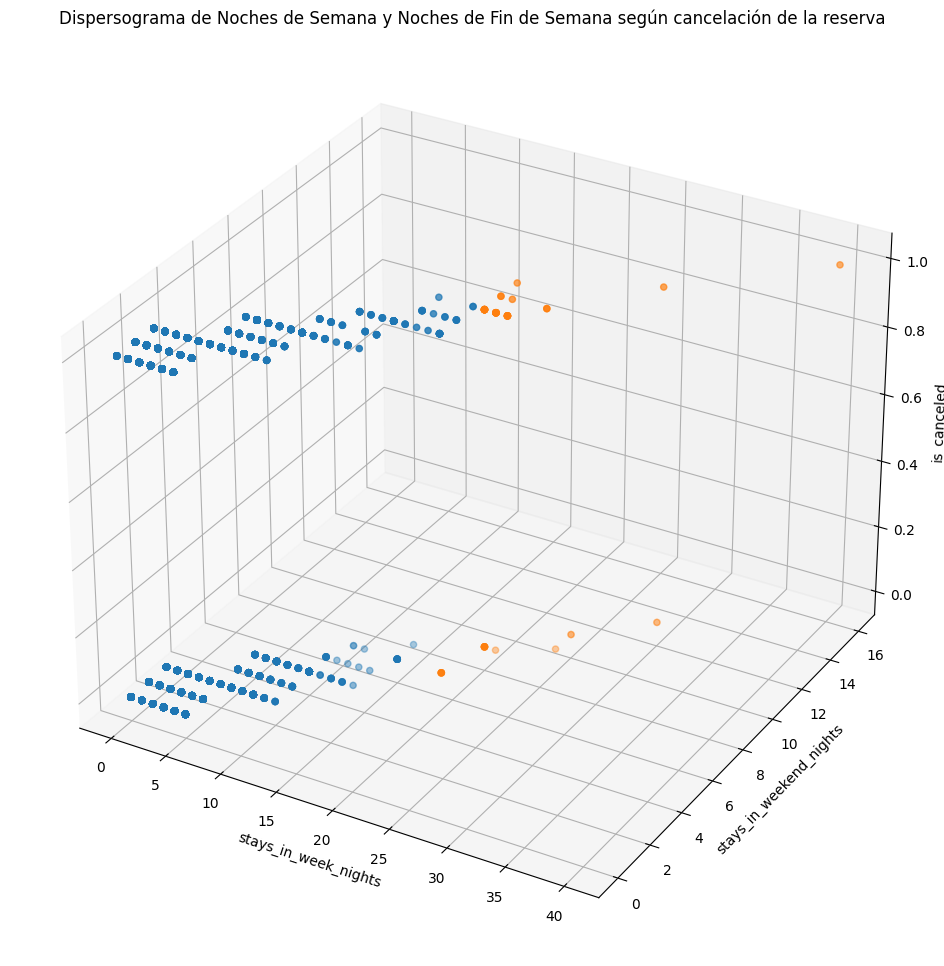

In [96]:
#Gráfico 3D
es_outlier = (ds_trabajo['mahalanobis_2'] > umbral)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

color=[f"C{n}" for n in (es_outlier*1)]
ax.scatter(ds_trabajo.stays_in_week_nights,ds_trabajo.stays_in_weekend_nights,ds_trabajo.is_canceled,c=color)
ax.set_xlabel('stays_in_week_nights')
ax.set_ylabel('stays_in_weekend_nights')
ax.set_zlabel('is_canceled')
plt.title('Dispersograma de Noches de Semana y Noches de Fin de Semana según cancelación de la reserva')
plt.show()

ds_trabajo = ds_trabajo.drop('mahalanobis_2',axis=1)

La distribución de estos outliers es muy pareja, lo que indica que no hay valores extremos que influyan significativamente en la relación entre ellas.

In [97]:
ds_trabajo.loc[es_outlier, 'stays_in_weekend_nights'] = ds_trabajo['stays_in_weekend_nights'].mean()
ds_trabajo.loc[es_outlier, 'stays_in_week_nights'] = ds_trabajo['stays_in_week_nights'].mean()

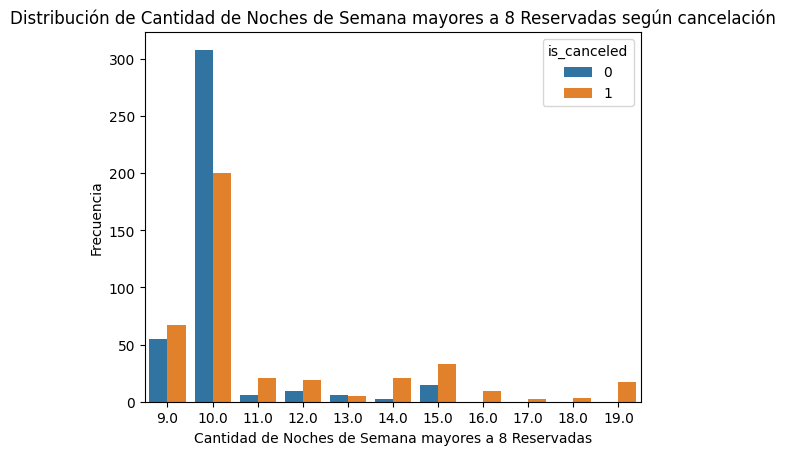

In [98]:
df = ds_trabajo.loc[ds_trabajo['stays_in_week_nights'] > 8]
grafico = sns.countplot(x=df['stays_in_week_nights'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de Noches de Semana mayores a 8 Reservadas')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de Noches de Semana mayores a 8 Reservadas según cancelación")

plt.show()

Para `previous_cancellations`, tenemos outliers superiores. En la notebook_1 habíamos analizado que la distribución de la variable respecto de `is_canceled` era muy variada, por lo tanto vamos a hacer un análisis más profundo de estos outliers para tomar una decisión.

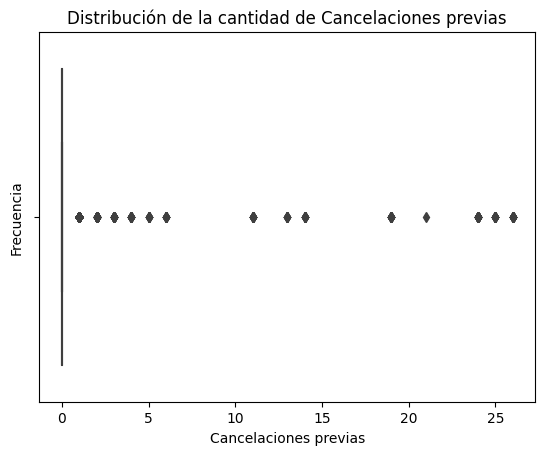

In [99]:
sns.boxplot(x=ds_trabajo["previous_cancellations"])
plt.xlabel('Cancelaciones previas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Cancelaciones previas')
plt.show()

In [100]:
#Cuartiles
Q1_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.25)
Q3_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.75)

#Rango intercuartil
IQR_previous_cancellations=Q3_previous_cancellations-Q1_previous_cancellations

#Limite inferior Outliers
out_inf=Q1_previous_cancellations-1.5*IQR_previous_cancellations
out_sup=Q3_previous_cancellations+1.5*IQR_previous_cancellations
print(out_inf)
print(out_sup)

0.0
0.0


In [101]:
outliers_inf = ds_trabajo[ds_trabajo['previous_cancellations'] < out_inf]
print("Outliers inferiores:", outliers_inf["previous_cancellations"].count())

outliers_sup = ds_trabajo[ds_trabajo['previous_cancellations'] > out_sup]
print("Outliers superiores:",outliers_sup["previous_cancellations"].count())

Outliers inferiores: 0
Outliers superiores: 4394


Observamos esta variabilidad respecto de `is_canceled` separando las cantidades en dos barplots para mejorar la legibilidad. La cantidad de cancelaciones previas podría estar relacionada a la antelación con la cual se hace una reserva. Creemos que será útil hacer un análisis multivariado de `previous_cancellations`, `lead_time` y el target `is_canceled`.

Vamos a analizar si hay outliers multivariados entre previous_cancellations y lead_time.

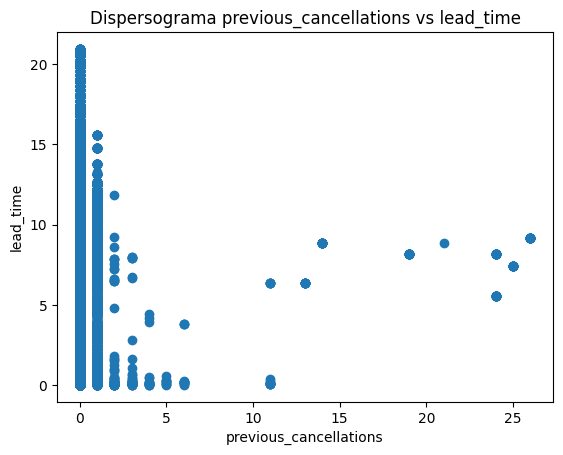

In [102]:
#Scatter Plot
plt.scatter(ds_trabajo.previous_cancellations,ds_trabajo.lead_time)
plt.title('Dispersograma previous_cancellations vs lead_time')
plt.xlabel('previous_cancellations')
plt.ylabel('lead_time')
plt.show()

In [103]:
#Calulo el vector de medias
vmedias=np.mean(ds_trabajo[['previous_cancellations','lead_time']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = ds_trabajo[['previous_cancellations','lead_time']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=ds_trabajo[['previous_cancellations','lead_time']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

ds_trabajo['mahalanobis']=mahal.diagonal()

<Axes: ylabel='mahalanobis'>

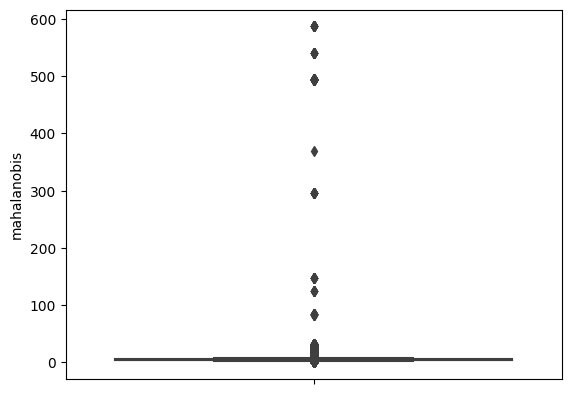

In [104]:
sns.boxplot(y=ds_trabajo.mahalanobis)

Vamos a definir un umbral de atípicos en 250.

In [105]:
umbral=250
# TODO: bajar el umbral hasta aprox. 90 / 85 / 80 / 75 ... de manera tal que los outliers superiores queden arriba de 5 cancelaciones previas
#Observaciones anómalas
ds_trabajo[ds_trabajo['mahalanobis']>umbral]

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,id,is_canceled,arrival_date,region,agent_specified,total_guests,more_than_zero_days_in_waiting_list,season,room_type_match,mahalanobis
152,Resort Hotel,9.166667,2.0,0.0,Offline TA/TO,TA/TO,0,26,0,0,...,352851e7-02ef-4ef5-8a89-9d0c0e981140,1,2015-10-04,Europe,1,2,0,Autumn,True,586.905845
337,Resort Hotel,8.133333,0.0,3.0,Offline TA/TO,TA/TO,0,19,0,0,...,6b53c345-eaa8-4bc9-8688-024b97948899,1,2015-09-03,Europe,0,2,0,Summer,True,295.143136
802,Resort Hotel,9.166667,2.0,0.0,Offline TA/TO,TA/TO,0,26,0,0,...,26530ece-101b-4ff1-8710-23bec5d71c32,1,2015-10-04,Europe,1,2,0,Autumn,True,586.905845
1640,Resort Hotel,7.400000,1.0,5.0,Groups,Corporate,0,25,0,0,...,ed2a9766-b46e-4259-8c92-8e5d24118d55,1,2015-09-15,Europe,1,2,0,Summer,True,539.569353
1837,Resort Hotel,9.166667,2.0,0.0,Offline TA/TO,TA/TO,0,26,0,0,...,94763cdb-82c1-4e9c-81bd-d3808b85e38e,1,2015-10-04,Europe,1,2,0,Autumn,True,586.905845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58340,Resort Hotel,9.166667,2.0,0.0,Offline TA/TO,TA/TO,0,26,0,0,...,91f6762b-1f12-4fff-a7fc-19eb9ce303a5,1,2015-10-04,Europe,1,2,0,Autumn,True,586.905845
58747,Resort Hotel,8.133333,2.0,5.0,Groups,TA/TO,0,24,0,0,...,3b059da3-7185-4ba7-b9fe-d6337eb3ac28,1,2015-09-02,Europe,1,2,0,Summer,True,493.516953
59002,Resort Hotel,8.133333,0.0,3.0,Offline TA/TO,TA/TO,0,19,0,0,...,5476618c-ab59-47f0-af30-fc932b124f60,1,2015-09-03,Europe,0,2,0,Summer,True,295.143136
59761,Resort Hotel,8.133333,2.0,5.0,Groups,TA/TO,0,24,0,0,...,5d0ccc3e-57ed-450a-9508-4dea33090dd0,1,2015-09-02,Europe,1,2,0,Summer,True,493.516953


Vemos que hay 90 registros outliers según Mahalanobis. Los vamos a visualizar en un scatter plot.

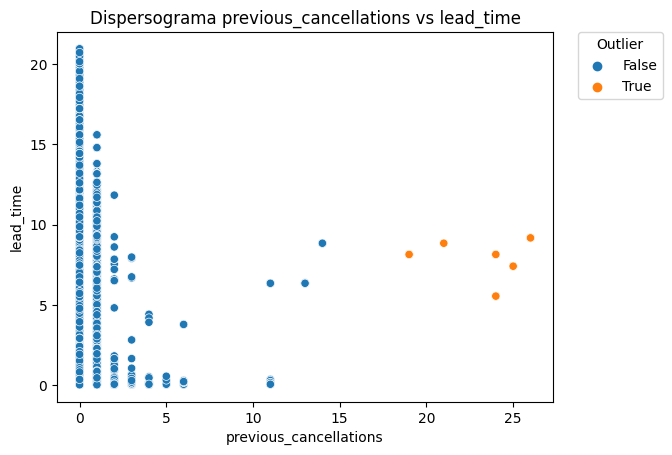

In [106]:
#Grafico scatter
es_outlier = (ds_trabajo['mahalanobis'] > umbral)

sns.scatterplot(x=ds_trabajo.previous_cancellations,y=ds_trabajo.lead_time, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma previous_cancellations vs lead_time')
plt.show()

ds_trabajo = ds_trabajo.drop('mahalanobis',axis=1)

TODO: vamos a poner los outliers superiores en la media entre 0 y 5

Vemos que estos pocos outliers están comprendidos entre las 10 y poco más de 25 cancelaciones previas. Y también observamos que estos se distribuyen entre los 0 y 10 meses de antelación. Creemos que es anormal que una persona tenga tantas cancelaciones previas, lo que nos hace pensar que pueden ser errores de carga. Vamos a analizar el comportamiento respecto de `is_canceled`.

In [107]:
#Calulo el vector de medias
vmedias=np.mean(ds_trabajo[['previous_cancellations','lead_time','is_canceled']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = ds_trabajo[['previous_cancellations','lead_time','is_canceled']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=ds_trabajo[['previous_cancellations','lead_time','is_canceled']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

ds_trabajo['mahalanobis_2']=mahal.diagonal()

In [108]:
# #Ordeno las distancias de menor a mayor
np.sort(ds_trabajo.mahalanobis_2)

array([  0.95184611,   0.95184611,   0.95184611, ..., 622.24306935,
       622.24306935, 622.24306935])

In [109]:
umbral=250

#Observacione anómalas
ds_trabajo[ds_trabajo['mahalanobis_2']>umbral]

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,id,is_canceled,arrival_date,region,agent_specified,total_guests,more_than_zero_days_in_waiting_list,season,room_type_match,mahalanobis_2
152,Resort Hotel,9.166667,2.0,0.0,Offline TA/TO,TA/TO,0,26,0,0,...,352851e7-02ef-4ef5-8a89-9d0c0e981140,1,2015-10-04,Europe,1,2,0,Autumn,True,622.243069
337,Resort Hotel,8.133333,0.0,3.0,Offline TA/TO,TA/TO,0,19,0,0,...,6b53c345-eaa8-4bc9-8688-024b97948899,1,2015-09-03,Europe,0,2,0,Summer,True,319.895492
802,Resort Hotel,9.166667,2.0,0.0,Offline TA/TO,TA/TO,0,26,0,0,...,26530ece-101b-4ff1-8710-23bec5d71c32,1,2015-10-04,Europe,1,2,0,Autumn,True,622.243069
1640,Resort Hotel,7.400000,1.0,5.0,Groups,Corporate,0,25,0,0,...,ed2a9766-b46e-4259-8c92-8e5d24118d55,1,2015-09-15,Europe,1,2,0,Summer,True,572.401313
1837,Resort Hotel,9.166667,2.0,0.0,Offline TA/TO,TA/TO,0,26,0,0,...,94763cdb-82c1-4e9c-81bd-d3808b85e38e,1,2015-10-04,Europe,1,2,0,Autumn,True,622.243069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58340,Resort Hotel,9.166667,2.0,0.0,Offline TA/TO,TA/TO,0,26,0,0,...,91f6762b-1f12-4fff-a7fc-19eb9ce303a5,1,2015-10-04,Europe,1,2,0,Autumn,True,622.243069
58747,Resort Hotel,8.133333,2.0,5.0,Groups,TA/TO,0,24,0,0,...,3b059da3-7185-4ba7-b9fe-d6337eb3ac28,1,2015-09-02,Europe,1,2,0,Summer,True,525.326557
59002,Resort Hotel,8.133333,0.0,3.0,Offline TA/TO,TA/TO,0,19,0,0,...,5476618c-ab59-47f0-af30-fc932b124f60,1,2015-09-03,Europe,0,2,0,Summer,True,319.895492
59761,Resort Hotel,8.133333,2.0,5.0,Groups,TA/TO,0,24,0,0,...,5d0ccc3e-57ed-450a-9508-4dea33090dd0,1,2015-09-02,Europe,1,2,0,Summer,True,525.326557


Parece que hay una relación compleja entre las tres variables. En particular, parece haber un patrón en el que hay una cantidad similar de cancelaciones previas en un rango específico de tiempo, pero las cancelaciones no están relacionadas con la antelación de la reserva. Por otro lado, hay una tendencia a cancelar después de un cierto número de cancelaciones previas, independientemente de la antelación de la reserva. Una de nuestras hipótesis, como dijimos, es que estos outliers pueden tratarse de un error en la carga de los datos.

Debido a lo poco probable que es que alguien cancele tantas veces una reserva, vamos a considerar estos valores como errores de carga. Vamos a corregirlos con la media.

In [110]:
media_columna = ds_trabajo.loc[es_outlier, 'previous_cancellations'].mean()
ds_trabajo.loc[es_outlier, 'previous_cancellations'] = media_columna

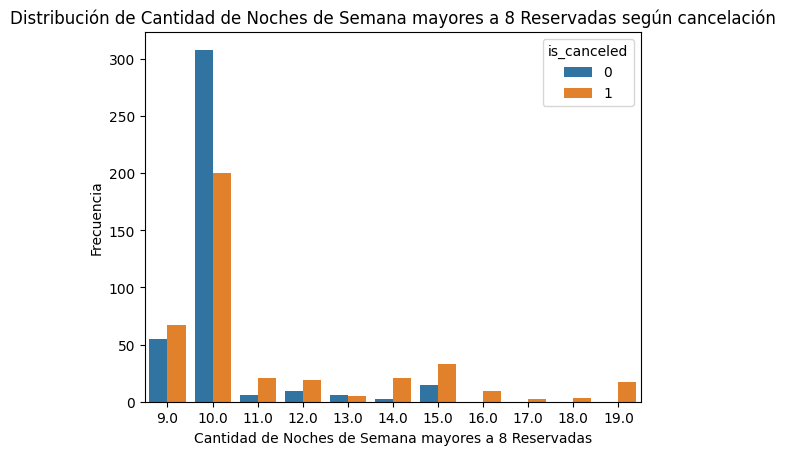

In [111]:
df = ds_trabajo.loc[ds_trabajo['stays_in_week_nights'] > 8]
grafico = sns.countplot(x=df['stays_in_week_nights'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de Noches de Semana mayores a 8 Reservadas')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de Noches de Semana mayores a 8 Reservadas según cancelación")

plt.show()

Para `previous_cancellations`, tenemos outliers superiores. En la notebook_1 habíamos analizado que la distribución de la variable respecto de `is_canceled` era muy variada, por lo tanto vamos a hacer un análisis más profundo de estos outliers para tomar una decisión.

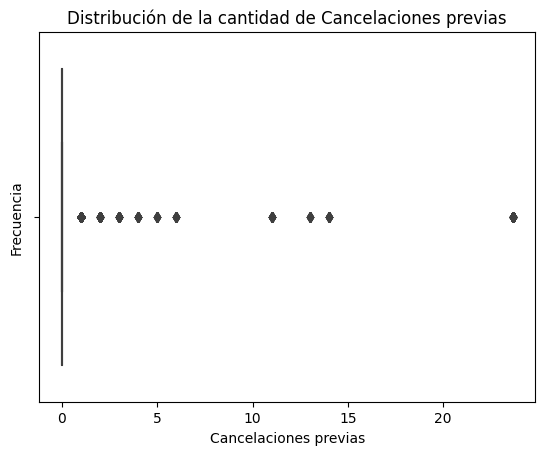

In [112]:
sns.boxplot(x=ds_trabajo["previous_cancellations"])
plt.xlabel('Cancelaciones previas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Cancelaciones previas')
plt.show()

In [113]:
#Cuartiles
Q1_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.25)
Q3_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.75)

#Rango intercuartil
IQR_previous_cancellations=Q3_previous_cancellations-Q1_previous_cancellations

#Limite inferior Outliers
out_inf=Q1_previous_cancellations-1.5*IQR_previous_cancellations
out_sup=Q3_previous_cancellations+1.5*IQR_previous_cancellations
print(out_inf)
print(out_sup)

0.0
0.0


In [114]:
outliers_inf = ds_trabajo[ds_trabajo['previous_cancellations'] < out_inf]
print("Outliers inferiores:", outliers_inf["previous_cancellations"].count())

outliers_sup = ds_trabajo[ds_trabajo['previous_cancellations'] > out_sup]
print("Outliers superiores:",outliers_sup["previous_cancellations"].count())

Outliers inferiores: 0
Outliers superiores: 4394


Observamos esta variabilidad respecto de `is_canceled` separando las cantidades en dos barplots para mejorar la legibilidad. La cantidad de cancelaciones previas podría estar relacionada a la antelación con la cual se hace una reserva. Creemos que será útil hacer un análisis multivariado de `previous_cancellations`, `lead_time` y el target `is_canceled`. TODO

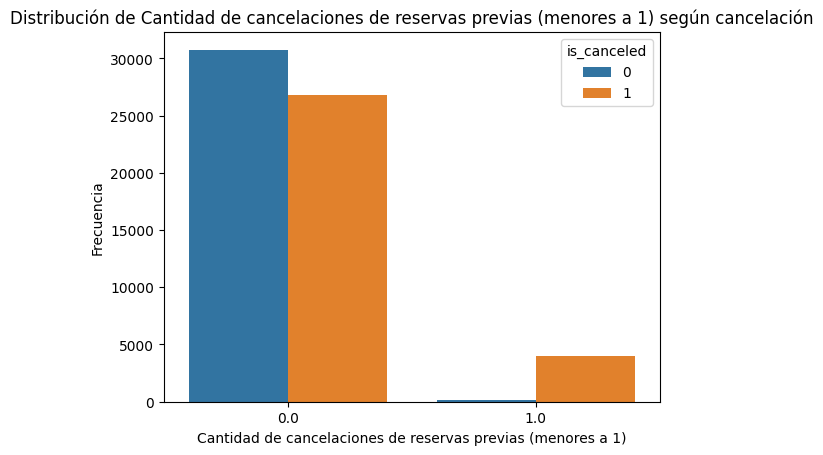

In [115]:
df = ds_trabajo.loc[ds_trabajo['previous_cancellations'] <= 1]
grafico = sns.countplot(x=df['previous_cancellations'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de cancelaciones de reservas previas (menores a 1)')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de cancelaciones de reservas previas (menores a 1) según cancelación")

plt.show()

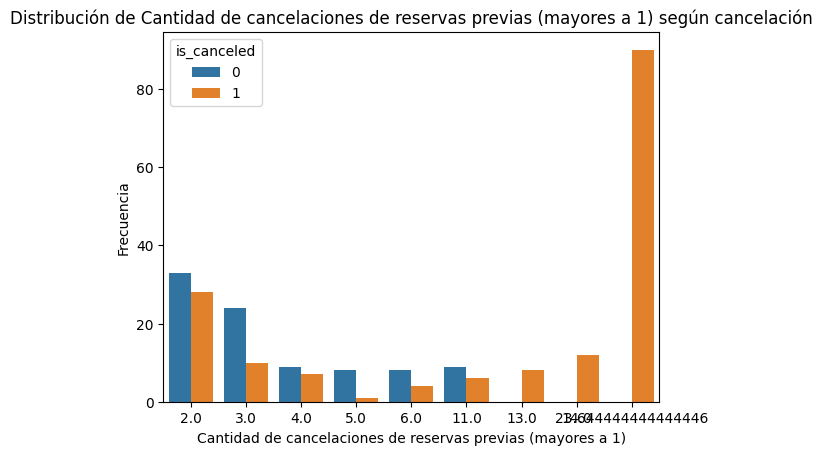

In [116]:
df = ds_trabajo.loc[ds_trabajo['previous_cancellations'] > 1]
grafico = sns.countplot(x=df['previous_cancellations'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de cancelaciones de reservas previas (mayores a 1)')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de cancelaciones de reservas previas (mayores a 1) según cancelación")

plt.show()

En cuanto a la variable `previous_bookings_not_canceled`, habíamos visto en la notebook_1 que tiene un comportamiento inverso a `previous_cancellations`: entre más reservas no canceladas, menor posibilidad de cancelación.

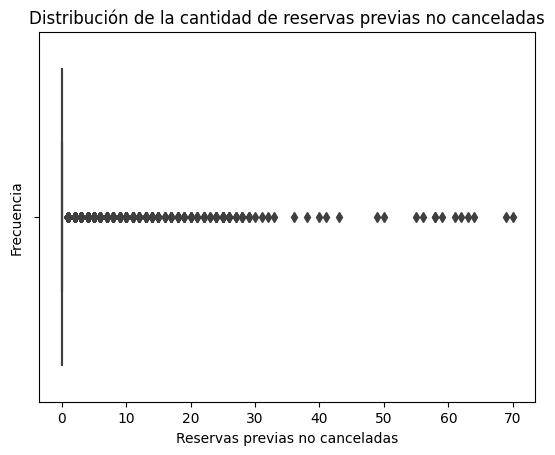

In [117]:
sns.boxplot(x=ds_trabajo["previous_bookings_not_canceled"])
plt.xlabel('Reservas previas no canceladas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de reservas previas no canceladas')
plt.show()

In [118]:
#Cuartiles
Q1_previous_bookings_not_canceled=np.quantile(ds_trabajo.previous_bookings_not_canceled,0.25)
Q3_previous_bookings_not_canceled=np.quantile(ds_trabajo.previous_bookings_not_canceled,0.75)

#Rango intercuartil
IQR_previous_bookings_not_canceled=Q3_previous_bookings_not_canceled-Q1_previous_bookings_not_canceled

#Limite inferior Outliers
out_inf=Q1_previous_bookings_not_canceled-1.5*IQR_previous_bookings_not_canceled
out_sup=Q3_previous_bookings_not_canceled+1.5*IQR_previous_bookings_not_canceled
print(out_inf)
print(out_sup)

0.0
0.0


In [119]:
outliers_inf = ds_trabajo[ds_trabajo['previous_bookings_not_canceled'] < out_inf]
print("Outliers inferiores:", outliers_inf["previous_bookings_not_canceled"].count())

outliers_sup = ds_trabajo[ds_trabajo['previous_bookings_not_canceled'] > out_sup]
print("Outliers superiores:",outliers_sup["previous_bookings_not_canceled"].count())

Outliers inferiores: 0
Outliers superiores: 1538


Hay pocos outliers. TODO: sumarla al analisis multivariado anterior.

Para `booking_changes`, observamos una cantidad más considerable de outliers superiores.

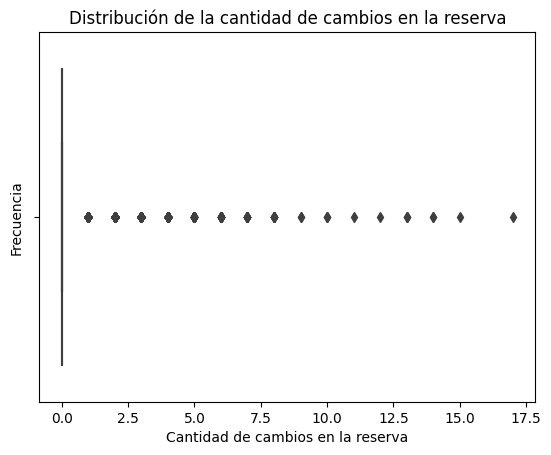

In [120]:
sns.boxplot(x=ds_trabajo["booking_changes"])
plt.xlabel('Cantidad de cambios en la reserva')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de cambios en la reserva')
plt.show()

In [121]:
#z-score modificado
mediana_booking_changes=np.median(ds_trabajo.booking_changes)
MAD=np.median(np.absolute(ds_trabajo.booking_changes-mediana_booking_changes))

ds_trabajo['zm_booking_changes']=(ds_trabajo.booking_changes - mediana_booking_changes)*0.6745/MAD

zm_booking_changes_inf = ds_trabajo[ds_trabajo['zm_booking_changes'] < 3.5]
print("Cantidad de registros con z-score menor a 3.5:", zm_booking_changes_inf["zm_booking_changes"].count())

zm_booking_changes_sup = ds_trabajo[ds_trabajo['zm_booking_changes'] > 3.5]
print("Cantidad de registros con z-score mayor a 3.5:", zm_booking_changes_sup["zm_booking_changes"].count())

# eliminamos la columna zm
ds_trabajo = ds_trabajo.drop('zm_booking_changes', axis=1)

Cantidad de registros con z-score menor a 3.5: 0
Cantidad de registros con z-score mayor a 3.5: 8317


Sin embargo, notamos que en todos los casos se cancela menos de lo que no. Creemos que esta columna podría no estar aportando información. Vamos a hacer un análisis multivariado. TODO

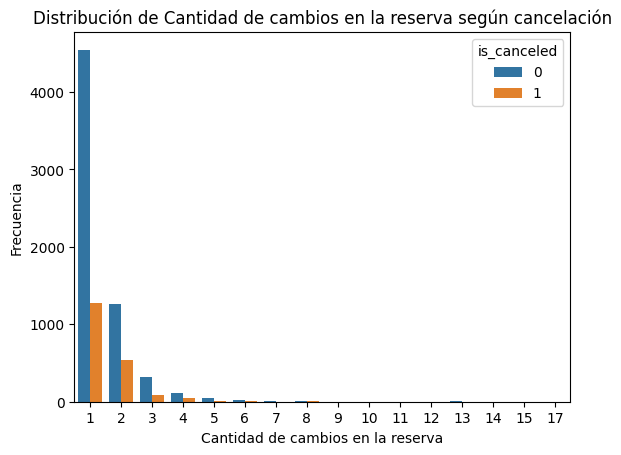

In [122]:
df = ds_trabajo.loc[ds_trabajo['booking_changes'] > 0]
grafico = sns.countplot(x=df['booking_changes'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de cambios en la reserva')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de cambios en la reserva según cancelación")

plt.show()

Para `adr`

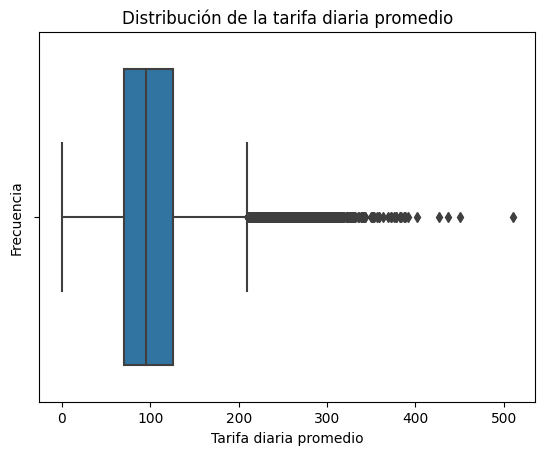

In [123]:
sns.boxplot(x=ds_trabajo["adr"])
plt.xlabel('Tarifa diaria promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de la tarifa diaria promedio')
plt.show()

In [124]:
#Cuartiles
Q1_adr =np.quantile(ds_trabajo.adr,0.25)
Q3_adr =np.quantile(ds_trabajo.adr,0.75)
IQR_adr=Q3_adr-Q1_adr
out_inf=Q1_adr-1.5*IQR_adr
out_sup=Q3_adr+1.5*IQR_adr
print(out_inf)
print(out_sup)
print(IQR_adr)
outliers_inf = ds_trabajo[ds_trabajo['adr'] < out_inf]
print("Outliers inferiores:", outliers_inf["adr"].count())
outliers_sup = ds_trabajo[ds_trabajo['adr'] > out_sup]
print("Outliers superiores:",outliers_sup["adr"].count())

-14.0
210.0
56.0
Outliers inferiores: 0
Outliers superiores: 2025


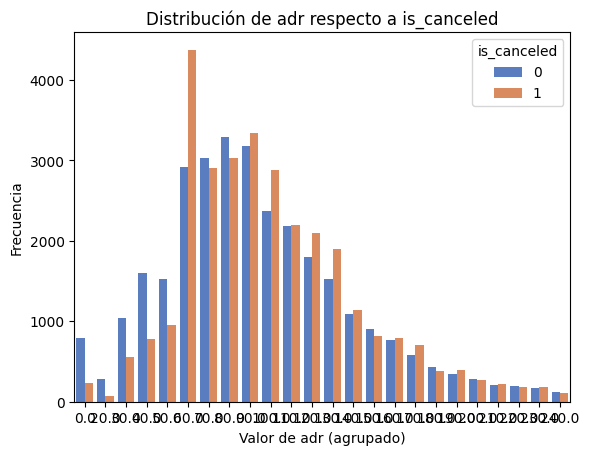

In [125]:

ds_trabajo['adr_group'] = (ds_trabajo['adr'] // 10) * 10
df = ds_trabajo.groupby('adr_group').filter(lambda x: len(x) > out_sup)
grafico = sns.countplot(x=df['adr_group'], hue='is_canceled', data=ds_trabajo, palette='muted')
plt.xlabel('Valor de adr (agrupado)')
plt.ylabel('Frecuencia')
plt.title("Distribución de adr respecto a is_canceled")
plt.show()

Podemos ver que apartir de los valores de adr con una media de 80 son muy aceptados, al haber poca taza de cancelados y que apartir de los mismos, el adr aumenta y su taza de cancelados se equipara."

Para `total_of_special_requests`

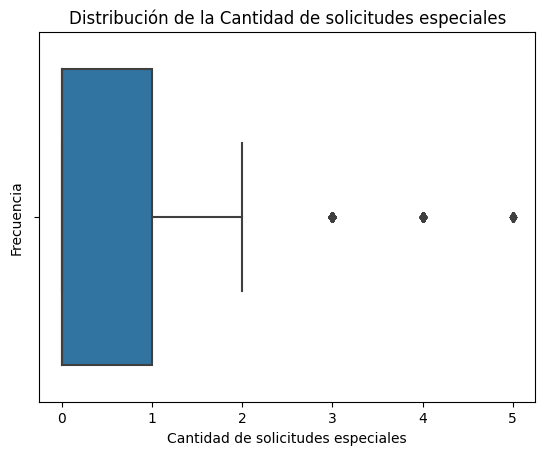

In [126]:
sns.boxplot(x=ds_trabajo["total_of_special_requests"])
plt.xlabel('Cantidad de solicitudes especiales')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Cantidad de solicitudes especiales')
plt.show()

In [127]:
#Cuartiles
Q1_total_of_special_requests =np.quantile(ds_trabajo.total_of_special_requests,0.25)
Q3_total_of_special_requests =np.quantile(ds_trabajo.total_of_special_requests,0.75)
IQR_total_of_special_requests=Q3_total_of_special_requests-Q1_total_of_special_requests
out_inf=Q1_total_of_special_requests-1.5*IQR_total_of_special_requests
out_sup=Q3_total_of_special_requests+1.5*IQR_total_of_special_requests
print(out_inf)
print(out_sup)
print(IQR_total_of_special_requests)
outliers_inf = ds_trabajo[ds_trabajo['total_of_special_requests'] < out_inf]
print("Outliers inferiores:", outliers_inf["total_of_special_requests"].count())
outliers_sup = ds_trabajo[ds_trabajo['total_of_special_requests'] > out_sup]
print("Outliers superiores:",outliers_sup["total_of_special_requests"].count())

-1.5
2.5
1.0
Outliers inferiores: 0
Outliers superiores: 1358


Para `total_guests`

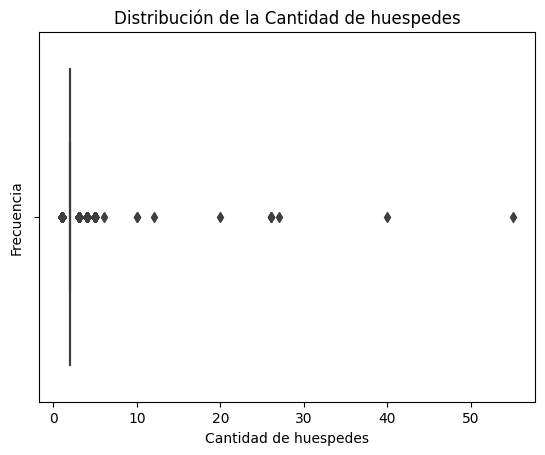

In [128]:
sns.boxplot(x=ds_trabajo["total_guests"])
plt.xlabel('Cantidad de huespedes')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Cantidad de huespedes')
plt.show()

In [129]:
#z-score modificado
mediana_total_guests=np.median(ds_trabajo.total_guests)
MAD=np.median(np.absolute(ds_trabajo.total_guests-mediana_total_guests))

ds_trabajo['zm_total_guests']=(ds_trabajo.total_guests - mediana_total_guests)*0.6745/MAD

zm_total_guests_inf = ds_trabajo[ds_trabajo['zm_total_guests'] < 3.5]
print("Cantidad de registros con z-score menor a 3.5:", zm_total_guests_inf["zm_total_guests"].count())

zm_total_guests = ds_trabajo[ds_trabajo['zm_total_guests'] > 3.5]
print("Cantidad de registros con z-score mayor a 3.5:", zm_total_guests["zm_total_guests"].count())

ds_trabajo = ds_trabajo.drop('zm_total_guests', axis=1)

Cantidad de registros con z-score menor a 3.5: 11411
Cantidad de registros con z-score mayor a 3.5: 7442


Para `market_segment`

market_segment
Online TA        29269
Offline TA/TO    12384
Groups           11545
Direct            5757
Corporate         2484
Complementary      359
Aviation           113
Undefined            2
Name: count, dtype: int64


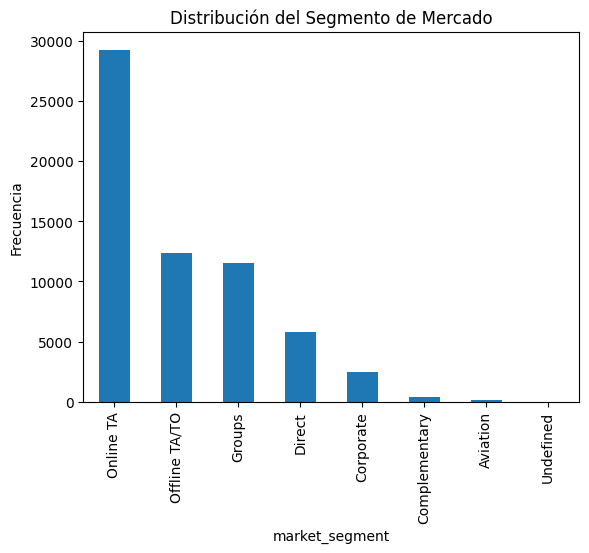

In [130]:
frecuencia = ds_trabajo['market_segment'].value_counts()
print(frecuencia)
plt.xlabel('Segmento de Mercado')
plt.ylabel('Frecuencia')
plt.title('Distribución del Segmento de Mercado')
frecuencia.plot(kind='bar')
plt.show()

Para `distribution_channel`

distribution_channel
TA/TO        51849
Direct        6799
Corporate     3172
GDS             89
Undefined        4
Name: count, dtype: int64


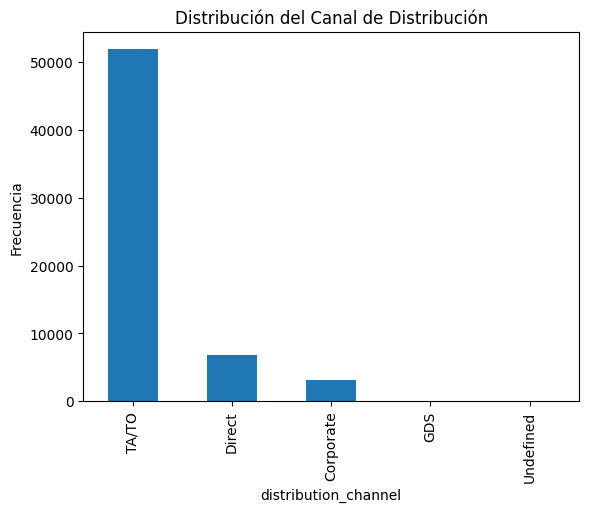

In [131]:
frecuencia = ds_trabajo['distribution_channel'].value_counts()
print(frecuencia)

plt.xlabel('Canal de Distribución')
plt.ylabel('Frecuencia')
plt.title('Distribución del Canal de Distribución')
frecuencia.plot(kind='bar')
plt.show()

Para `deposit_type`

deposit_type
No Deposit    51763
Non Refund    10150
Name: count, dtype: int64


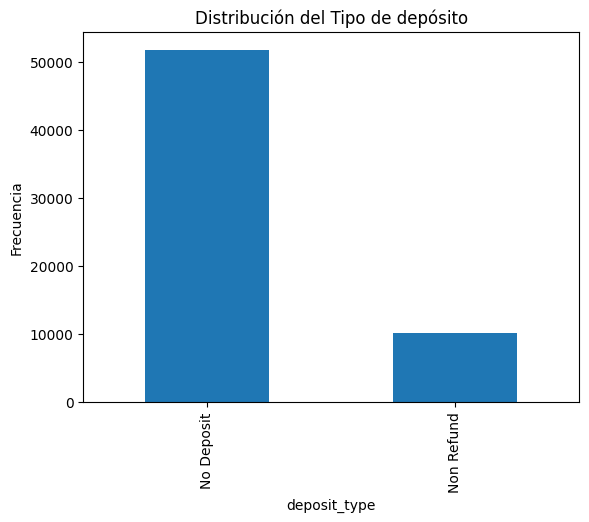

In [132]:
frecuencia = ds_trabajo['deposit_type'].value_counts()
print(frecuencia)

plt.xlabel('Tipo de depósito')
plt.ylabel('Frecuencia')
plt.title('Distribución del Tipo de depósito')
frecuencia.plot(kind='bar')
plt.show()

Para `customer_type`

customer_type
Transient          47449
Transient-Party    12168
Contract            2296
Name: count, dtype: int64


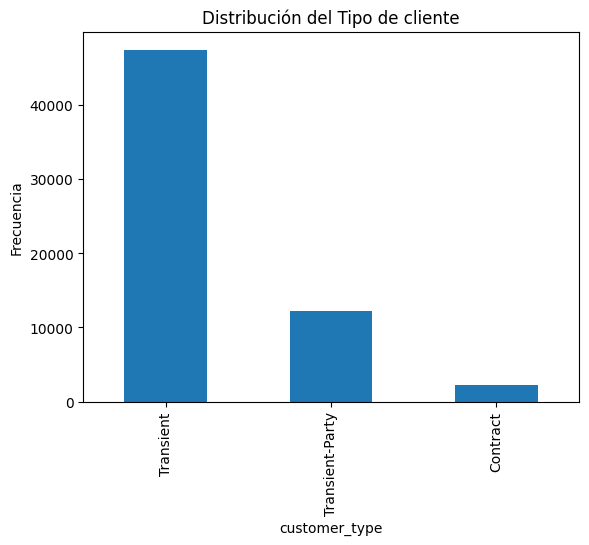

In [133]:
frecuencia = ds_trabajo['customer_type'].value_counts()
print(frecuencia)

plt.xlabel('Tipo de cliente')
plt.ylabel('Frecuencia')
plt.title('Distribución del Tipo de cliente')
frecuencia.plot(kind='bar')
plt.show()

In [134]:
ds_trabajo.duplicated().sum()

0

In [135]:
ds_trabajo.reservation_status_date

0        2016-08-25
1        2015-11-01
2        2016-10-14
3        2016-11-29
4        2017-03-26
            ...    
61908    2017-01-23
61909    2016-09-03
61910    2017-05-11
61911    2015-07-08
61912    2016-04-09
Name: reservation_status_date, Length: 61913, dtype: object

In [136]:
ds_trabajo = ds_trabajo.drop(ds_trabajo[ds_trabajo['distribution_channel'] == 'Undefined'].index)
ds_trabajo = ds_trabajo.drop(ds_trabajo[ds_trabajo['market_segment'] == 'Undefined'].index)

In [137]:
ds_trabajo['reservation_status_date'] = pd.to_datetime(ds_trabajo.reservation_status_date)
ds_trabajo.reservation_status_date = ds_trabajo.reservation_status_date.apply(lambda x: x.timestamp())
ds_trabajo['arrival_date'] = pd.to_datetime(ds_trabajo.arrival_date)
ds_trabajo.arrival_date = ds_trabajo.arrival_date.apply(lambda x: x.timestamp())



In [138]:
ds_trabajo = ds_trabajo.drop("reservation_status_date",axis=1)
ds_trabajo = ds_trabajo.drop("adr_group",axis=1)
ds_trabajo = ds_trabajo.drop("id",axis=1)

Vamos a realizar one hot enconding en las columnas categóricas para poder entrenar nuestro modelo.

In [139]:
# One hot encoding para variables categoricas
ds_trabajo = pd.get_dummies(ds_trabajo, columns=['hotel',
                                                 'market_segment',
                                                 'distribution_channel',
                                                 'is_repeated_guest',
                                                 'deposit_type',
                                                 'customer_type',
                                                 'agent_specified',
                                                 'more_than_zero_days_in_waiting_list',
                                                 'season',
                                                 'region',
                                                 'room_type_match'], drop_first=True)
ds_trabajo.head()


,lead_time,stays_in_weekend_nights,stays_in_week_nights,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,total_of_special_requests,is_canceled,arrival_date,...,agent_specified_1,more_than_zero_days_in_waiting_list_1,season_Spring,season_Summer,season_Winter,region_Americas,region_Asia,region_Europe,region_Oceania,room_type_match_True
0,1.633333,1.0,2.0,0.0,0,0,115.5,1,1,1.473034e+09,...,True,False,False,True,False,True,False,False,False,True
1,0.133333,0.0,1.0,0.0,0,0,42.0,0,0,1.446250e+09,...,False,False,False,False,False,False,False,True,False,True
2,0.833333,0.0,1.0,0.0,0,0,229.0,2,0,1.476317e+09,...,True,False,False,False,False,False,False,True,False,True
3,0.866667,2.0,5.0,0.0,0,0,75.0,0,1,1.481501e+09,...,True,False,False,False,False,False,False,True,False,True
4,3.466667,2.0,5.0,0.0,0,0,75.0,1,0,1.489882e+09,...,True,False,False,False,True,False,False,True,False,True


Separamos el dataset de entrenamiento usando una proporción de 70%-30% y estratificando las columnas.

In [140]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x=ds_trabajo.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

Vemos las proporciones de cancelado / no cancelado para revisar que estas categorías esten bien distirbuidas.

In [141]:
num_cancelados = sum(y_train)
num_no_cancelados = len(y_train) - num_cancelados
prop_cancelados = num_cancelados / len(y_train)

print("Número de cancelaciones:", num_cancelados)
print("Número de no cancelaciones:", num_no_cancelados)
print("Proporción de cancelaciones:", prop_cancelados)


Número de cancelaciones: 21559
Número de no cancelaciones: 21777
Proporción de cancelaciones: 0.49748477016798964


Vamos a hacer un primer árbol de decisión simple, especificando una profundidad de 20, con criterio de entropía y con 10 como mínimo número de muestras por hoja.

In [142]:
#Creamos un clasificador con hiperparámetros 
tree_model = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 20, 
                                         min_samples_leaf=10,
                                         random_state=2) 
#Entrenamos el modelo
model = tree_model.fit(X = x_train, y = y_train)

Realizamos una primera predicción sobre el set de test con este árbol.

In [143]:
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

Visualizamos su matriz de confusión.

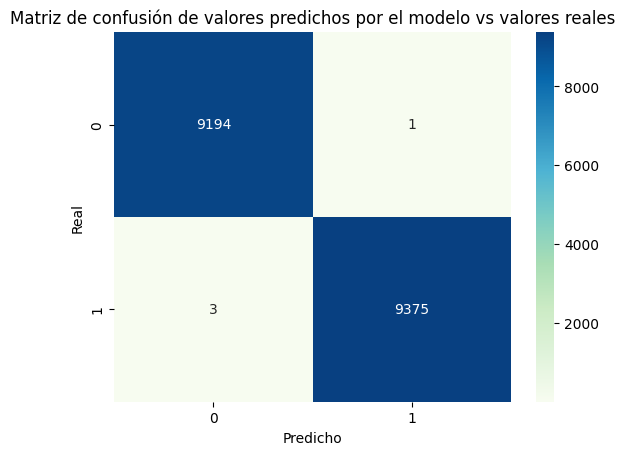

In [144]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Vamos a analizar sus métricas.

In [145]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.9997846336079255
Recall: 0.9996801023672425
Precision: 0.9998933447098977
f1 score: 0.9997867121680709


Podemos ver que el modelo tiene una precisión del 80.2% y un recall de 79.4% aproximadamente. Por otro lado, el f1 score indica que el modelo está prediciendo correctamente el 80% de las observaciones positivas en el conjunto de datos, al mismo tiempo que mantiene un bajo número de falsos positivos. En el caso de predecir si una reserva será cancelada o no, creemos que una alta precisión es importante, ya que puede ser costoso y perjudicial para el negocio si se cancelan reservas que en realidad no lo necesitaban. Creemos entonces que es importante reducir la cantidad de falsos positivos, es decir, predecir que una reserva se cancelará cuando en realidad no lo hará. Por lo tanto, elegimos optimizar la métrica de precisión para reducir la cantidad de reservas que se cancelan innecesariamente.

Vamos a buscar hiperparámetros por medio de Grid Search, optimizando la métrica de precisión. En esta iteración, vamos a buscar los mejores hiperparámetros con profundidades de 10, 20, 30 y 40, una cantidad mínima de muestras por hoja de 5, 10 y 15 y algunos valores para la poda. Probaremos esto con 5 folds y con el criterio de Gini.

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
params = {'max_depth': [10, 20, 30, 40],
          'min_samples_leaf': [5, 10, 15],
          'ccp_alpha': [0.0, 0.001, 0.01, 0.1]}
tree_model = DecisionTreeClassifier(criterion="gini")
grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           scoring='precision', 
                           cv=5)
grid_search.fit(X=x_train, y=y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 10}
Best cross-validation score: 0.999628920883174


Mostramos las métricas para nuestra iteración con la configuración de hiperparámetros mencionada anteriormente y hacemos su matriz de confusión.

In [147]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_tree_model = grid_search.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_tree_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


Accuracy: 0.9996231088138696
Recall: 0.999360204734485
Precision: 0.9998933105729222
f1 score: 0.9996266865767159


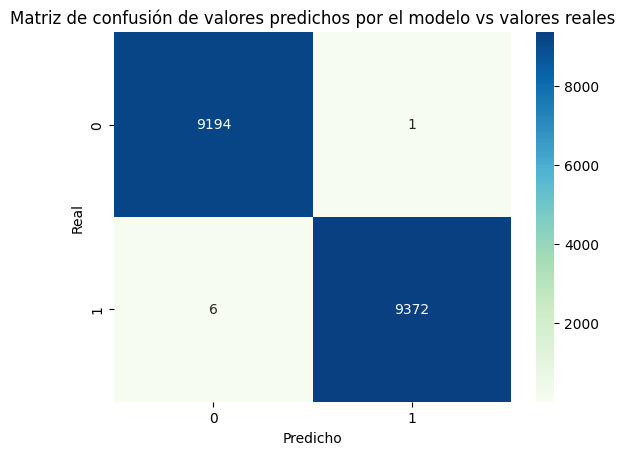

In [148]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Vemos que en estas iteraciones mejoró mucho la precisión (aprox. 89%), que es lo que buscabamos, sin embargo, el recall ha disminuido considerablemente (aprox. 60%). Con estos hiperparámetros, el modelo tiene una alta probabilidad de acertar cuando clasifica una reserva como cancelada, pero es posible que no esté identificando todas las reservas que en realidad fueron canceladas. Puede ser que el modelo está identificando correctamente la mayoría de las cancelaciones importantes, pero puede estar perdiendo algunas cancelaciones importantes. Vamos a buscar otra configuración de hiperparámetros que mejore la precisión pero que no a costa de empeorar tanto nuestro recall.

Para estas nuevas iteraciones, vamos a cambiar el método a Random Search Cross Validation. Usaremos otros conjuntos de parámetros: criterio de Gini o de Entropía, mínima cantidad de muestras por hoja entre 1 y 15, máxima profundidad entre 20 y 40, entre otros especificados en el siguiente código. Por último, vamos a incrementar el número de folds a 7, ya que consideramos que tenemos una buena cantidad de datos de prueba para subdividirlo en 7 subconjuntos, y la complejidad del modelo lo amerita. Además, queremos mantener una evaluación precisa del rendimiento de nuestro modelo, por lo que 7 nos parece una cantidad adecuada para probar maximizar el uso de datos y reducir la variabilidad en la evaluación.

In [149]:
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import make_scorer
import sklearn.metrics as sk_metrics

#Cantidad de combinaciones que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,20)),
               'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.002,n), 
               'max_depth':list(range(20,40))}
                
#Cantidad de splits para el Cross Validation
folds=7

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk_metrics.precision_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

print("Best parameters:", randomcv.best_params_)
print("Best cross-validation score:", randomcv.best_score_)
print(randomcv.best_estimator_)

NameError: name 'make_scorer' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_tree_model = randomcv.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_tree_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


Accuracy: 0.7999784633607926
Recall: 0.7718063552996375
Precision: 0.8212867355043686
f1 score: 0.7957781320433182


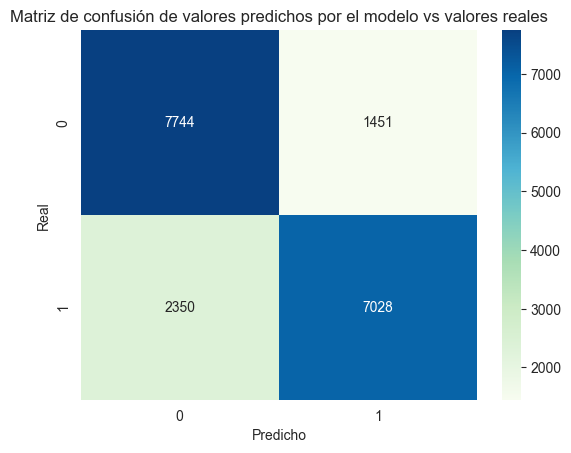

In [ ]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Tras varias iteraciones del Random Search con esta configuración de hiperparámetros, nos vamos a quedar con una que creemos, para nuestro enfoque, es de las mejores que conseguimos en esta tanda. La configuración de hiperparámetros es `min_samples_split`:8, `min_samples_leaf`:5, `max_depth`:24, `criterion`:gini, `ccp_alpha`:0.00022, `folds`:7. Vamos a hacer la predicción en particular para esos hiperparámetros para mostrar sus métricas y ver su matriz de confusión.

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# tree = DecisionTreeClassifier(min_samples_leaf=13,min_samples_split=19,max_depth=27,criterion='entropy',ccp_alpha=0.0)
# tree = DecisionTreeClassifier(max_depth=21, min_samples_leaf=18, min_samples_split=18, criterion='gini', random_state=2)
best_tree = DecisionTreeClassifier(ccp_alpha=0.00022222222222222223, max_depth=24,
                       min_samples_leaf=5, min_samples_split=8, random_state=2)
best_tree.fit(X = x_train, y = y_train)

y_pred = best_tree.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)

Accuracy: 0.7953480859311904
Recall: 0.7494135210066112
Precision: 0.8288713291661752
f1 score: 0.7871422971383771


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

#Predicción sobre el set de evaluacion
y_pred= best_tree.predict(x_test)

#Reporte
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      9195
           1       0.83      0.75      0.79      9378

    accuracy                           0.80     18573
   macro avg       0.80      0.80      0.80     18573
weighted avg       0.80      0.80      0.79     18573



Podemos ver que con esta configuración de hiperparámetros, nuestro modelo logra predecir correctamente el 82.8% de reservas realmente no canceladas y el 74.9% de las que se cancelan. Por otro lado, el accuracy nos dice que clasifica correctamente el 79.5% de las reservas. El f1 score sugiere que hay un buen equilibrio entre precisión y recall, siendo éste de 0.78. 

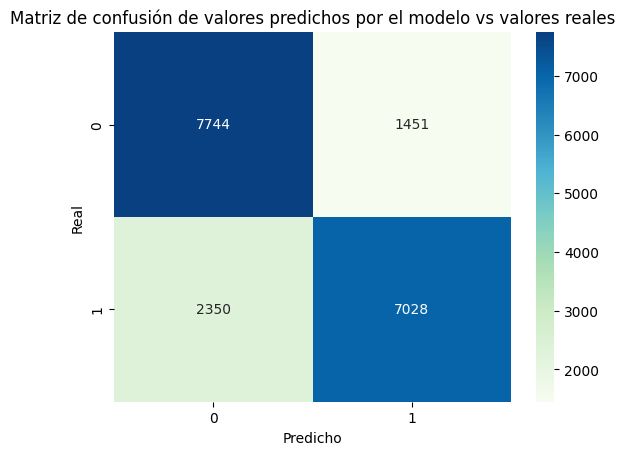

In [ ]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd
y_pred_proba = pd.Series(best_tree.predict_proba(x_test)[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('AUC-ROC:', roc_auc)


AUC-ROC: 0.8795480113755297


En cuanto al área bajo la curva ROC, vemos que es de 0.879 por lo que el modelo tiene una buena capacidad para distinguir entre reservas canceladas y no canceladas. Graficamos la curva ROC.

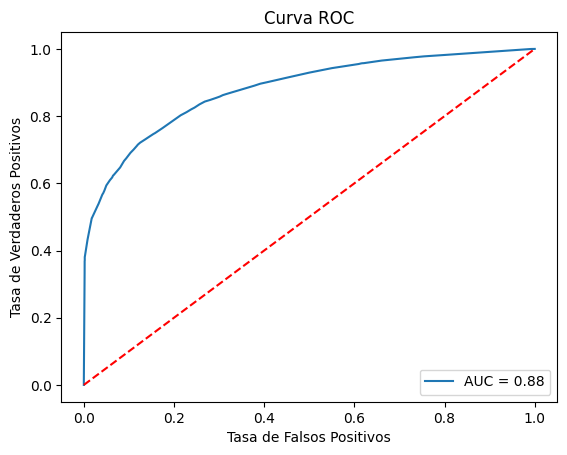

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener las probabilidades de la clase positiva
y_probs = best_tree.predict_proba(x_test)[:,1]

# Calcular la curva ROC
fpr, tpr, umbrales = roc_curve(y_test, y_probs)

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, y_probs)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


Observemos la importancia de características. Nuestro modelo considera que el tipo de depósito es la característica más importante para clasificar. Seguido de este, es el tiempo de antelación con el que se hace una reserva y si el tipo de habitación reservado es el mismo que el asignado.

In [ ]:
sorted(list(zip(ds_trabajo_x.columns.to_list(), best_tree.feature_importances_)), key=lambda x: -x[1])

[('deposit_type_Non Refund', 0.4153558470747266),
 ('lead_time', 0.10463325006576288),
 ('room_type_match_True', 0.10302760202973422),
 ('total_of_special_requests', 0.09412178825209401),
 ('previous_cancellations', 0.08291718708691982),
 ('market_segment_Online TA', 0.06318062620815788),
 ('arrival_date', 0.031803588370766495),
 ('adr', 0.02239336100813431),
 ('customer_type_Transient-Party', 0.021441727924589815),
 ('booking_changes', 0.01918456069593212),
 ('customer_type_Transient', 0.011534352862614224),
 ('previous_bookings_not_canceled', 0.00824851014736362),
 ('region_Europe', 0.007161552734810213),
 ('hotel_Resort Hotel', 0.006281499069990733),
 ('stays_in_week_nights', 0.004040802264055442),
 ('market_segment_Direct', 0.0032000989808378456),
 ('stays_in_weekend_nights', 0.0014736452235097211),
 ('total_guests', 0.0),
 ('market_segment_Complementary', 0.0),
 ('market_segment_Corporate', 0.0),
 ('market_segment_Groups', 0.0),
 ('market_segment_Offline TA/TO', 0.0),
 ('distribut

Por último, vamos a graficar el árbol y a analizarlo. Graficaremos 4 niveles de profundidad ya que más de eso se vuelve ilegible.

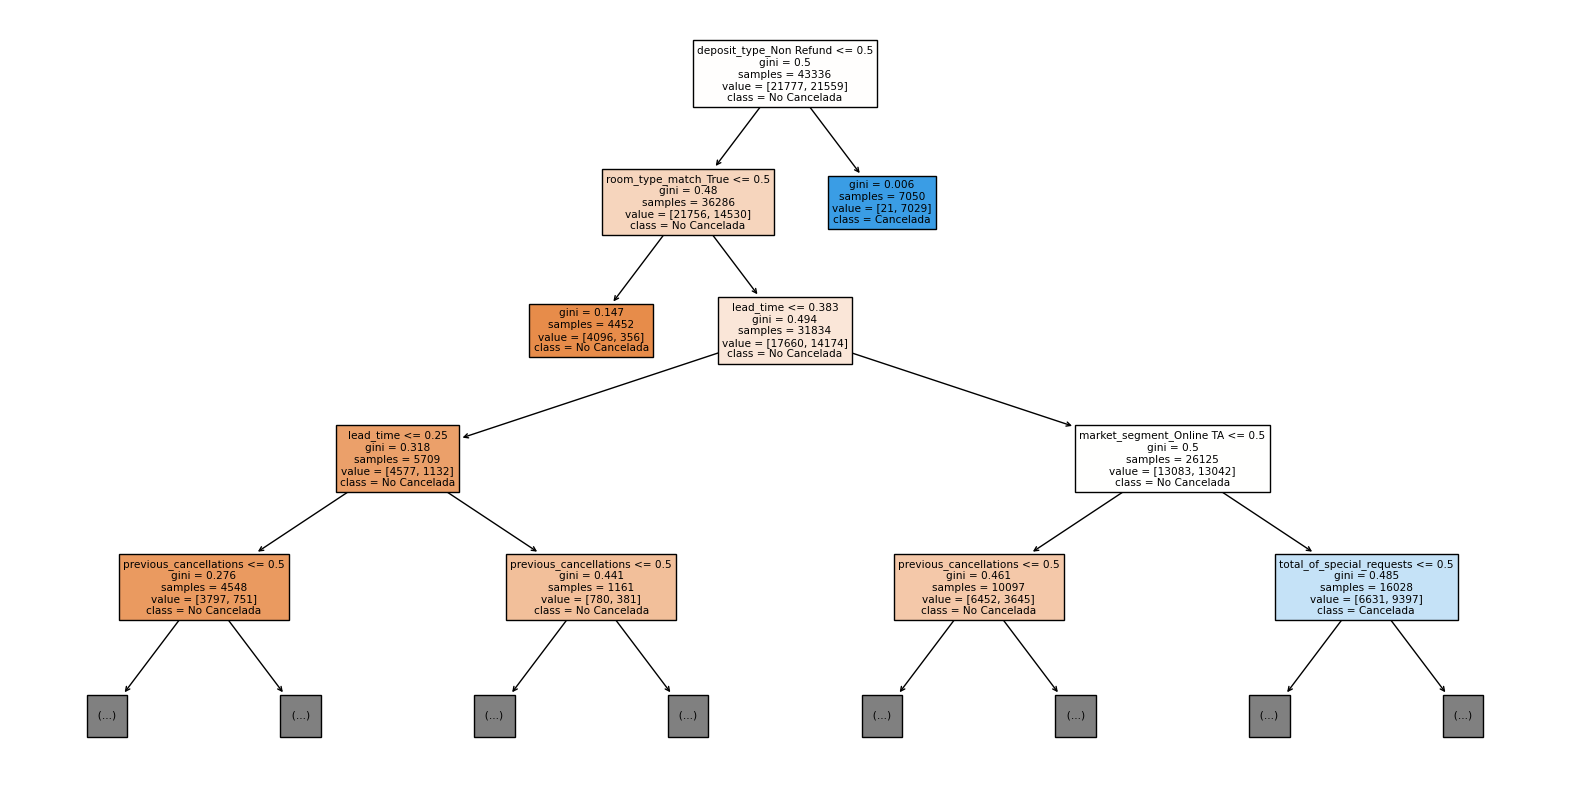

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_tree, max_depth=4, filled=True, feature_names=x_train.columns, class_names=['No Cancelada', 'Cancelada'])
plt.show()


Como mencionamos anteriormente, vemos que la característica más importante es `deposit_type`: la primera condición que evalúa es si se depositó para garantizar la reserva o no. En particular, vemos que si se depositó, ya la clasifica como cancelada con bastante seguridad. Pensamos que esto podría deberse a que no es usual que un cliente pague la totalidad de una reserva (normalmente se paga una seña, creemos que quienes pagan la totalidad pueden ser empresas o ciertas entidades adineradas). Por otro lado, si no se depositó, lo siguiente que evalúa es si el cuarto asignado es el mismo que el reservado, si no lo es vemos que la clasifica con bastante seguridad como no cancelada. A partir de acá, al menos en esta porción del gráfico, hará preguntas más precisas para ver cómo lo clasifica. Lo siguiente que preguntará es si el tiempo de antelación es menor que 4 meses si es que el cuarto no coincidió. Si lo es, indaga si es aún menor que 2.5 meses, y a partir de acá evalúa las cancelaciones previas cualquiera sea el caso. Si la antelación de la reserva es mayor a 4 meses, consultará por si el segmento de mercado es Online TA, caso afirmativo preguntará por la cantidad de peticiones especiales y caso contrario preguntará también por las cancelaciones previas. El árbol continua hasta los 24 niveles de profundidad, no los graficaremos porque no es legible.

Exportamos el modelo en formato pickle.

In [ ]:
import pickle

with open('modelo.pickle', 'wb') as archivo:
    pickle.dump(best_tree, archivo)